# **Importing Functions**

In [38]:
import torch
import torch.nn as nn
from tqdm.auto import tqdm

from torchvision.utils import make_grid



import numpy as np
import os
import matplotlib.pyplot as plt

import torch
import torchvision
from torchvision import models, transforms, datasets

import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

# **Building Generator**

In [39]:
# Building UNET


class DownSample(nn.Module):
    def __init__(self, Input_Channels, Output_Channels):
        super(DownSample, self).__init__()
        # nn.Conv2d(in_channel, out_channel, kernel, stride, padding)
        self.model = nn.Sequential(
                     nn.Conv2d(Input_Channels, Output_Channels, 4, 2, 1, bias=False),
                     nn.LeakyReLU(0.2)
                     )

    def forward(self, x):
        down = self.model(x)
        return down


class Upsample(nn.Module):
    def __init__(self, Input_Channels, Output_Channels):
        super(Upsample, self).__init__()
        
        self.model = nn.Sequential( 
                     nn.ConvTranspose2d(Input_Channels, Output_Channels, 4, 2, 1, bias=False),
                     nn.InstanceNorm2d(Output_Channels),
                     nn.ReLU(inplace=True),)

    def forward(self, x, skip_input):
        x = self.model(x)
        x = torch.cat((x, skip_input), 1)
        return x


class Generator(nn.Module):
    def __init__(self, in_channels=3, out_channels=3):
        super(Generator, self).__init__()

        self.down1 = DownSample(in_channels, 64)
        self.down2 = DownSample(64, 128)
        self.down3 = DownSample(128, 256)
        self.down4 = DownSample(256, 512)
        self.down5 = DownSample(512, 512)
        self.down6 = DownSample(512, 512)
        self.down7 = DownSample(512, 512)
        self.down8 = DownSample(512, 512)

        self.up1 = Upsample(512, 512)
        self.up2 = Upsample(1024, 512)
        self.up3 = Upsample(1024, 512)
        self.up4 = Upsample(1024, 512)
        self.up5 = Upsample(1024, 256)
        self.up6 = Upsample(512, 128)
        self.up7 = Upsample(256, 64)

        self.final = nn.Sequential(
            nn.Upsample(scale_factor=2),
            nn.ZeroPad2d((1, 0, 1, 0)),
            nn.Conv2d(128, 3, 4, padding=1), # out_channels
            nn.Tanh(),
        )

    def forward(self, x):
        # U-Net generator with skip connections from encoder to decoder

        d1 = self.down1(x)
        d2 = self.down2(d1)
        d3 = self.down3(d2)
        d4 = self.down4(d3)
        d5 = self.down5(d4)
        d6 = self.down6(d5)
        d7 = self.down7(d6)
        d8 = self.down8(d7)
        u1 = self.up1(d8, d7)
        u2 = self.up2(u1, d6)
        u3 = self.up3(u2, d5)
        u4 = self.up4(u3, d4)
        u5 = self.up5(u4, d3)
        u6 = self.up6(u5, d2)
        u7 = self.up7(u6, d1)
        u8 = self.final(u7)
        return u8


# **Building Discriminator - PatchGAN**

In [40]:

# Building Discriminator

class Discriminator(nn.Module):
    def __init__(self, in_channels=3,):
        super(Discriminator, self).__init__()

        
        self.model = nn.Sequential(
                     nn.Conv2d(6, 64, 4, 2, 1, bias=False),
                     nn.LeakyReLU(0.2, inplace=True),

                     nn.Conv2d(64, 128, 4, 2, 1, bias=False),
                     nn.LeakyReLU(0.2, inplace=True),

                     nn.Conv2d(128, 256, 4, 2, 1, bias=False),
                     nn.LeakyReLU(0.2, inplace=True),

                     nn.Conv2d(256, 512, 4, 2, 1, bias=False),
                     nn.LeakyReLU(0.2, inplace=True),

                     nn.ZeroPad2d((1, 0, 1, 0)),
                     nn.Conv2d(512, 1, 4, padding=1, bias=False)
                     
                     )

        
    def forward(self, img_A, img_B):
        # Here we are concatenating the images on their channels
        img_input = torch.cat((img_A, img_B), 1)
        return self.model(img_input)

# **Checking Generator and Discriminator Models**

In [41]:
image = torch.rand((1,3,256,256))
out_channels = 3
generator = Generator()
k = generator(image)
print(k.shape)

torch.Size([1, 3, 256, 256])


In [42]:
image1 = torch.rand((1,3,256,256))
image2 = torch.rand((1,3,256,256))

out_channels = 3
discriminator = Discriminator()
k = discriminator(image1,image2)
print(k.shape)

torch.Size([1, 1, 16, 16])


# **Loading Data.......**

In [43]:
data_dir = "/content/drive/MyDrive/Generative Adversarial Network/Pix2Pix GAN/maps"

data_transform = transforms.Compose([
    transforms.Resize((256, 512)),
    transforms.CenterCrop((256, 512)),
    # transforms.RandomVerticalFlip(p=0.5),
    transforms.ToTensor(),
    transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])
])

dataset_train = datasets.ImageFolder(root=os.path.join(data_dir, "train"), transform=data_transform)
dataset_val = datasets.ImageFolder(root=os.path.join(data_dir, "val"), transform=data_transform)

dataloader_train = torch.utils.data.DataLoader(dataset_train, batch_size=24, shuffle=True, num_workers=2)
dataloader_val = torch.utils.data.DataLoader(dataset_val, batch_size=24, shuffle=True, num_workers=2)

In [44]:
print(len(dataset_train))
print(len(dataset_val))

1096
1127


# **Defining Print function for showing Images**

In [45]:
def print_images(image_tensor, num_images):
    
    images = DeNormalize(image_tensor)
    images = images.detach().cpu()
    image_grid = make_grid(images[:num_images], nrow=5)
    plt.imshow(image_grid.permute(1, 2, 0).squeeze())
    plt.show()

# **Checking Loaded images**

In [46]:
images,_ = next(iter(dataloader_train))
images.shape

torch.Size([24, 3, 256, 512])

In [47]:
Normalization_Values = (0.5, 0.5, 0.5), (0.5, 0.5, 0.5)
def DeNormalize(tensor_of_image):
  return tensor_of_image * Normalization_Values[1][0] + Normalization_Values[0][0]

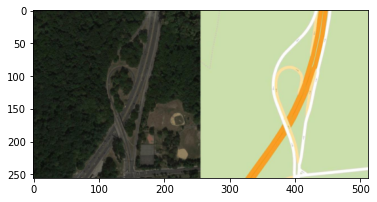

In [48]:
images,_ = next(iter(dataloader_train))

for image in images:  
  plt.imshow(DeNormalize(image).permute(1,2,0))
  plt.show()
  break;

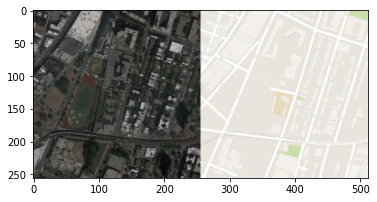

In [49]:
images,_ = next(iter(dataloader_train))

plt.imshow(DeNormalize(images[5]).permute(1,2,0))
plt.show()


# **Defining Loss Functions**

In [50]:
loss_comparison = nn.BCEWithLogitsLoss() 
L1_loss = nn.L1Loss()

# **Discriminator Training Function**

In [51]:
def discriminator_training(inputs,targets,discriminator_opt):     

        discriminator_opt.zero_grad()
        
       
        # Passing real image and getting loss
        
        output = discriminator(inputs, targets) 
        label = torch.ones(size = output.shape, dtype=torch.float, device=device)
        
        real_loss = loss_comparison(output, label) 
        
        # Passing Generated image and getting loss
        
        gen_image = generator(inputs).detach()
         
        fake_output = discriminator(inputs, gen_image)
        fake_label = torch.zeros(size = fake_output.shape, dtype=torch.float, device=device) 
        
        fake_loss = loss_comparison(fake_output, fake_label)

        Total_loss = (real_loss + fake_loss)/2

        Total_loss.backward()
        
        discriminator_opt.step()

        return Total_loss

# **Generator Training Function**

In [52]:
def generator_training(inputs,targets, generator_opt, L1_lambda):
          
            generator_opt.zero_grad()
            
            generated_image = generator(inputs)
            
            disc_output = discriminator(inputs, generated_image)
            desired_output = torch.ones(size = disc_output.shape, dtype=torch.float, device=device)
            
            generator_loss = loss_comparison(disc_output, desired_output) + L1_lambda * torch.abs(generated_image-targets).sum()
            generator_loss.backward()
            generator_opt.step()

            return generator_loss, generated_image

# **Starting Training Process........**

In [53]:
L1_lambda = 100
NUM_EPOCHS= 100
lr=0.0002 
beta1=0.5
beta2=0.999
device = 'cuda'

In [54]:
discriminator_opt = optim.Adam(discriminator.parameters(), lr=lr, betas=(beta1, beta2))
generator_opt = optim.Adam(generator.parameters(), lr=lr, betas=(beta1, beta2))

discriminator = discriminator.to(device)
generator = generator.to(device)

In [55]:
for epoch in range(NUM_EPOCHS+1):
    print(f"Training epoch {epoch+1}")
    for images,_ in tqdm(dataloader_train):
       # Splitting the image 

       inputs = images[:,:,:,:256].to(device)
       targets = images[:,:,:,256:].to(device)

       # Train Discriminator

       Disc_Loss = discriminator_training(inputs,targets,discriminator_opt)

       # Train Geneerator
       for i in range(2):
            Gen_Loss, generator_image = generator_training(inputs,targets, generator_opt, L1_lambda)

    if (epoch % 5) == 0:
         print_images(inputs,5)
         print_images(generator_image,5)
         print_images(targets,5)


Output hidden; open in https://colab.research.google.com to view.

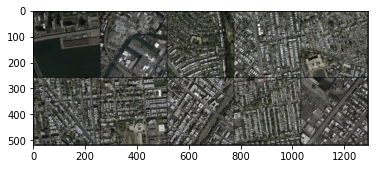

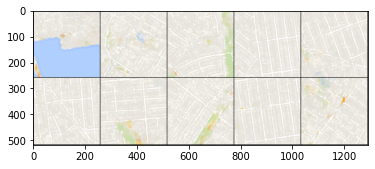

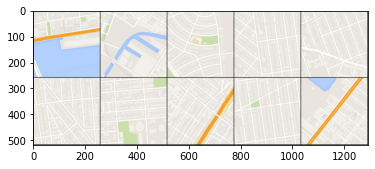

In [56]:
test_imgs,_ = next(iter(dataloader_val))


satellite = test_imgs[:,:,:,:256].to(device)
maps = test_imgs[:,:,:,256:].to(device)

gen = generator(satellite)
#gen = gen[0]

satellite = satellite.detach().cpu()
gen = gen.detach().cpu()
maps = maps.detach().cpu()

print_images(satellite,10)
print_images(gen,10)
print_images(maps,10)
